# **TUGAS 1 : Supervised Learning**

**KELOMPOK 7** :

Gaung Taqwa Indraswara (235150207111043)

Muhammad Fauzan (235150201111044)

Ferrel Destatiananda Edwardo (235150207111044)

Muhammad Fatir Zaira (23515020011039)

# **LOADING DATA & IMPORT LIBRARIES**

In [ ]:
import kagglehub
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
path = kagglehub.dataset_download("blastchar/telco-customer-churn")
print("Path to dataset files:", path)

files = os.listdir(path)
print("Files in dataset folder:", files)

Path to dataset files: /kaggle/input/telco-customer-churn
Files in dataset folder: ['WA_Fn-UseC_-Telco-Customer-Churn.csv']


In [ ]:
data_path = os.path.join(path, 'WA_Fn-UseC_-Telco-Customer-Churn.csv')
data = pd.read_csv(data_path)

# **EDA**

## **Understanding Data**

In [ ]:
print(data)

      customerID  gender  SeniorCitizen Partner Dependents  tenure  \
0     7590-VHVEG  Female              0     Yes         No       1   
1     5575-GNVDE    Male              0      No         No      34   
2     3668-QPYBK    Male              0      No         No       2   
3     7795-CFOCW    Male              0      No         No      45   
4     9237-HQITU  Female              0      No         No       2   
...          ...     ...            ...     ...        ...     ...   
7038  6840-RESVB    Male              0     Yes        Yes      24   
7039  2234-XADUH  Female              0     Yes        Yes      72   
7040  4801-JZAZL  Female              0     Yes        Yes      11   
7041  8361-LTMKD    Male              1     Yes         No       4   
7042  3186-AJIEK    Male              0      No         No      66   

     PhoneService     MultipleLines InternetService OnlineSecurity  ...  \
0              No  No phone service             DSL             No  ...   
1        

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


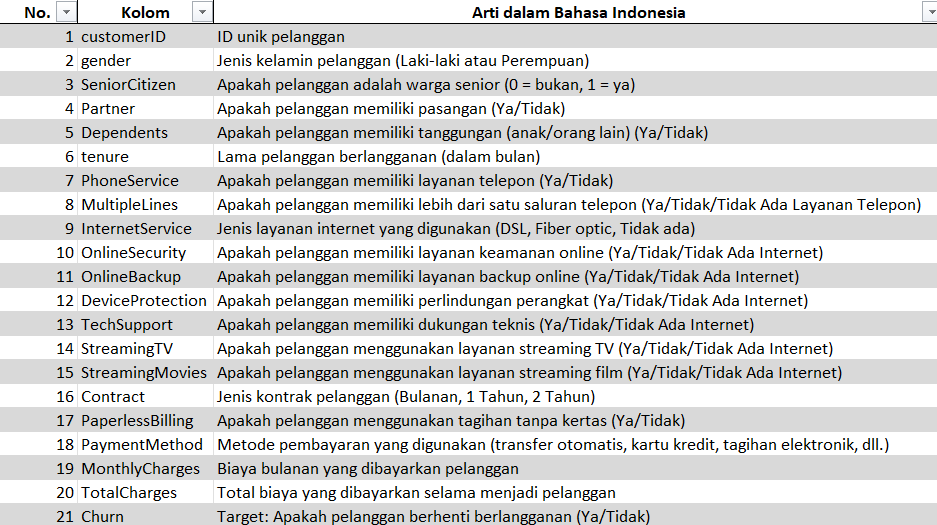

Dari data.info() dapat dilihat bahwa ada 3 kolom numerik dan 17 kolom bertipe object, namun dilihat dari print(data), sebenarnya kolom `TotalCharges` adalah kolom numerik namun di simpan sebagai string/object, lalu ada juga kolom biner `SeniorCitizen` yang di simpan dalam integer padahal kolom biner lainnya tersimpan dalam string yes dan no, beberapa ketidakkonsistenan tipe data ini menjadi conern kami dalam tahap-tahap selanjutnya

In [ ]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


Karena `describe()` hanya menampilkan kolom numerik maka ditampilkanlah 3 kolom ini, namun masalahnya untuk `SeniorCitizen` adalah kolom binary 1 dan 0 dan klom `TotalCharges` yang sebenarnya adalah kolom numerik masih belum tertampilkan karena masih dalam bentuk tipe data object

In [ ]:
data['Churn'].value_counts()

,count
Churn,
No,5174
Yes,1869


In [ ]:
percentages = data['Churn'].value_counts(normalize=True) * 100
percentages.round(2)

,proportion
Churn,
No,73.46
Yes,26.54


Dari persebaran target bisa dilihat bahwa dataset ini cukup imbalance dengan record churn berkisar antara 26% dari total keseluruhan data, insight ini akan kami tindak lanjuti dengan melakukan stratify train-test split nanti di bagian modeling

In [ ]:
unique_values = []

for col in data.columns:
    if col != 'customerID':
        unique_values.append({
            'Column': col,
            'Unique Values': data[col].unique(),
            'Len unique values': len(data[col].unique())
        })

unique_per_col = pd.DataFrame(unique_values)
unique_per_col

,Column,Unique Values,Len unique values
0,gender,"[Female, Male]",2
1,SeniorCitizen,"[0, 1]",2
2,Partner,"[Yes, No]",2
3,Dependents,"[No, Yes]",2
4,tenure,"[1, 34, 2, 45, 8, 22, 10, 28, 62, 13, 16, 58, ...",73
5,PhoneService,"[No, Yes]",2
6,MultipleLines,"[No phone service, No, Yes]",3
7,InternetService,"[DSL, Fiber optic, No]",3
8,OnlineSecurity,"[No, Yes, No internet service]",3
9,OnlineBackup,"[Yes, No, No internet service]",3


Kode diatas membantu kami untuk menentukan encoding yang cocok untuk masing-masing kolom

## **Missing Value**

In [ ]:
data.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


Setelah di cek tidak ada data yang null jika menggunakan isnull

In [ ]:
datav = data.copy()

In [ ]:
datav['TotalCharges'] = pd.to_numeric(datav['TotalCharges'], errors='coerce')

In [ ]:
datav.isna().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


namun setelah tipe data kolom `TotalCharges` diubah menjadi numerik ternyata ada kolom yang null, mungkin ada record yang menyimpan string yang berisi tidak hanya angka

In [ ]:
mask = pd.to_numeric(data['TotalCharges'], errors='coerce').isna()
data.loc[mask, 'TotalCharges'].unique()

array([' '], dtype=object)

Benar ternyata yang gagal dikonversi menjadi numerik  dan menjadi null adalah data berisi spasi, untuk selanjutnya akan kita telusuri apakah data null ini layak di drop atau di imputasi

In [ ]:
print(data[data['TotalCharges'] == ' '])

      customerID  gender  SeniorCitizen Partner Dependents  tenure  \
488   4472-LVYGI  Female              0     Yes        Yes       0   
753   3115-CZMZD    Male              0      No        Yes       0   
936   5709-LVOEQ  Female              0     Yes        Yes       0   
1082  4367-NUYAO    Male              0     Yes        Yes       0   
1340  1371-DWPAZ  Female              0     Yes        Yes       0   
3331  7644-OMVMY    Male              0     Yes        Yes       0   
3826  3213-VVOLG    Male              0     Yes        Yes       0   
4380  2520-SGTTA  Female              0     Yes        Yes       0   
5218  2923-ARZLG    Male              0     Yes        Yes       0   
6670  4075-WKNIU  Female              0     Yes        Yes       0   
6754  2775-SEFEE    Male              0      No        Yes       0   

     PhoneService     MultipleLines InternetService       OnlineSecurity  ...  \
488            No  No phone service             DSL                  Yes  ... 

setelah dilihat ternyata data null ini merupakan data para pelanggan yang baru bergabung kurang dari 1 bulan, berikut adalah evidence nya kami temukan dari data diatas untuk kami lakukan penanganan missing value ini
- `tenure` = 0 untuk semua 11 record → artinya pelanggan baru mendaftar.

- `TotalCharges` = " " → memang belum membayar apa-apa karena belum ada tagihan berjalan.

- `MonthlyCharges` sudah ada nilainya → menunjukkan paket yang dipilih sudah diketahui.

- `Churn` = No → mereka masih aktif saat data dicatat.

maka dengan ini kami tetapkan untuk imputasi nilai 0 di kolom **TotalCharges** nya

In [ ]:
datav['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
datav['TotalCharges'].fillna(0, inplace=True)

<ipython-input-127-ea5c995dc89e>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  datav['TotalCharges'].fillna(0, inplace=True)


In [ ]:
datav['TotalCharges'].isnull().sum()

np.int64(0)

In [ ]:
datav.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## Data Distribution

Untuk mendapatkan ke konsistenan di tahap EDA kolom `SeniorCitizen` kamu buat untuk memiliki value Yes atau No agar sama seperti kolom biner lainnya dan mempermudah pembuatan grafik nantinya

In [ ]:
datav['SeniorCitizen'] = datav['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

In [ ]:
num_col = datav.select_dtypes(include=['int64', 'float64']).columns
cat_col = datav.select_dtypes(include=['object']).columns.drop('customerID')

print(num_col)
print(cat_col)

Index(['tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')
Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn'],
      dtype='object')


### Analisis untuk Fitur Numerikal

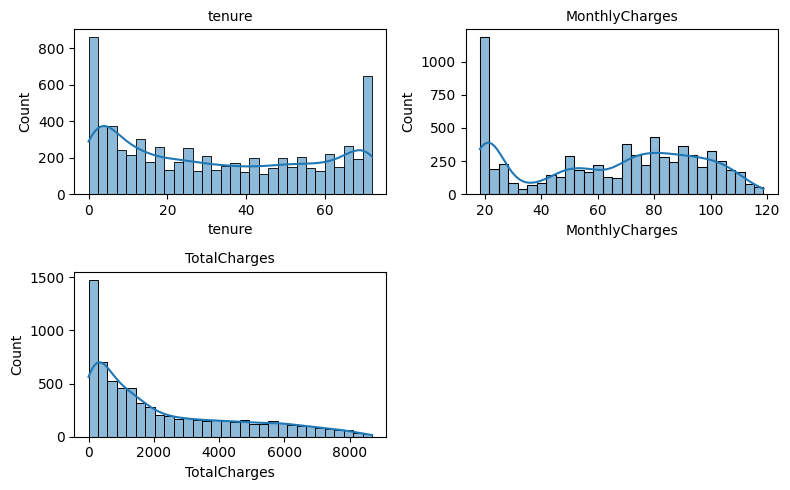

In [ ]:
plt.figure(figsize=(8, 5))

# Banyak subplot berdasarkan jumlah kolom
for idx, col in enumerate(num_col):
    plt.subplot(2, (len(num_col)+1)//2, idx+1)  # 2 baris, sisanya otomatis
    sns.histplot(datav[col], kde=True, bins=30)
    plt.title(col, fontsize=10)
    plt.tight_layout()

plt.show()

Dari distribusi data numerik bisa dilihat bahwa

- `Tenure`:

  - Menunjukkan distribusi bimodal dengan puncak di nilai rendah (sekitar 0-1 bulan) dan nilai tinggi (sekitar 70 bulan)
  - Mengindikasikan dua kelompok pelanggan yang dominan: pelanggan baru dan pelanggan loyal jangka panjang
  - Distribusi cukup merata di antara kedua puncak tersebut


- `MonthlyCharges` :

  - Menunjukkan distribusi yang cukup merata dengan sedikit right-skewed
  - Memiliki puncak di nilai rendah (sekitar 20) dan beberapa puncak kecil di sepanjang range nilai
  - Range nilai berkisar antara 20-120


- `TotalCharges` :

  - Sangat right-skewed (distribusi ekor panjang ke kanan)
  - Mayoritas nilai berada di range rendah dengan ekor yang memanjang ke nilai yang lebih tinggi
  - Ini menunjukkan bahwa sebagian besar pelanggan memiliki total biaya yang relatif rendah, dengan beberapa pelanggan yang memiliki nilai ekstrem tinggi

  Kondisi diatas membuat pemilihan scaler menjadi penting agar model tidak bias terhadap nilai ekstrem. Karena karakteristik RobustScaler yang menggunakan median dan IQR, ia lebih tahan terhadap outlier dibandingkan StandardScaler atau MinMaxScaler. Oleh karena itu, saya memilih menggunakan RobustScaler untuk menangani distribusi data numerik tersebut agar hasil preprocessing lebih stabil dan representatif.

### Analisis Untuk Fitur Kategorikal

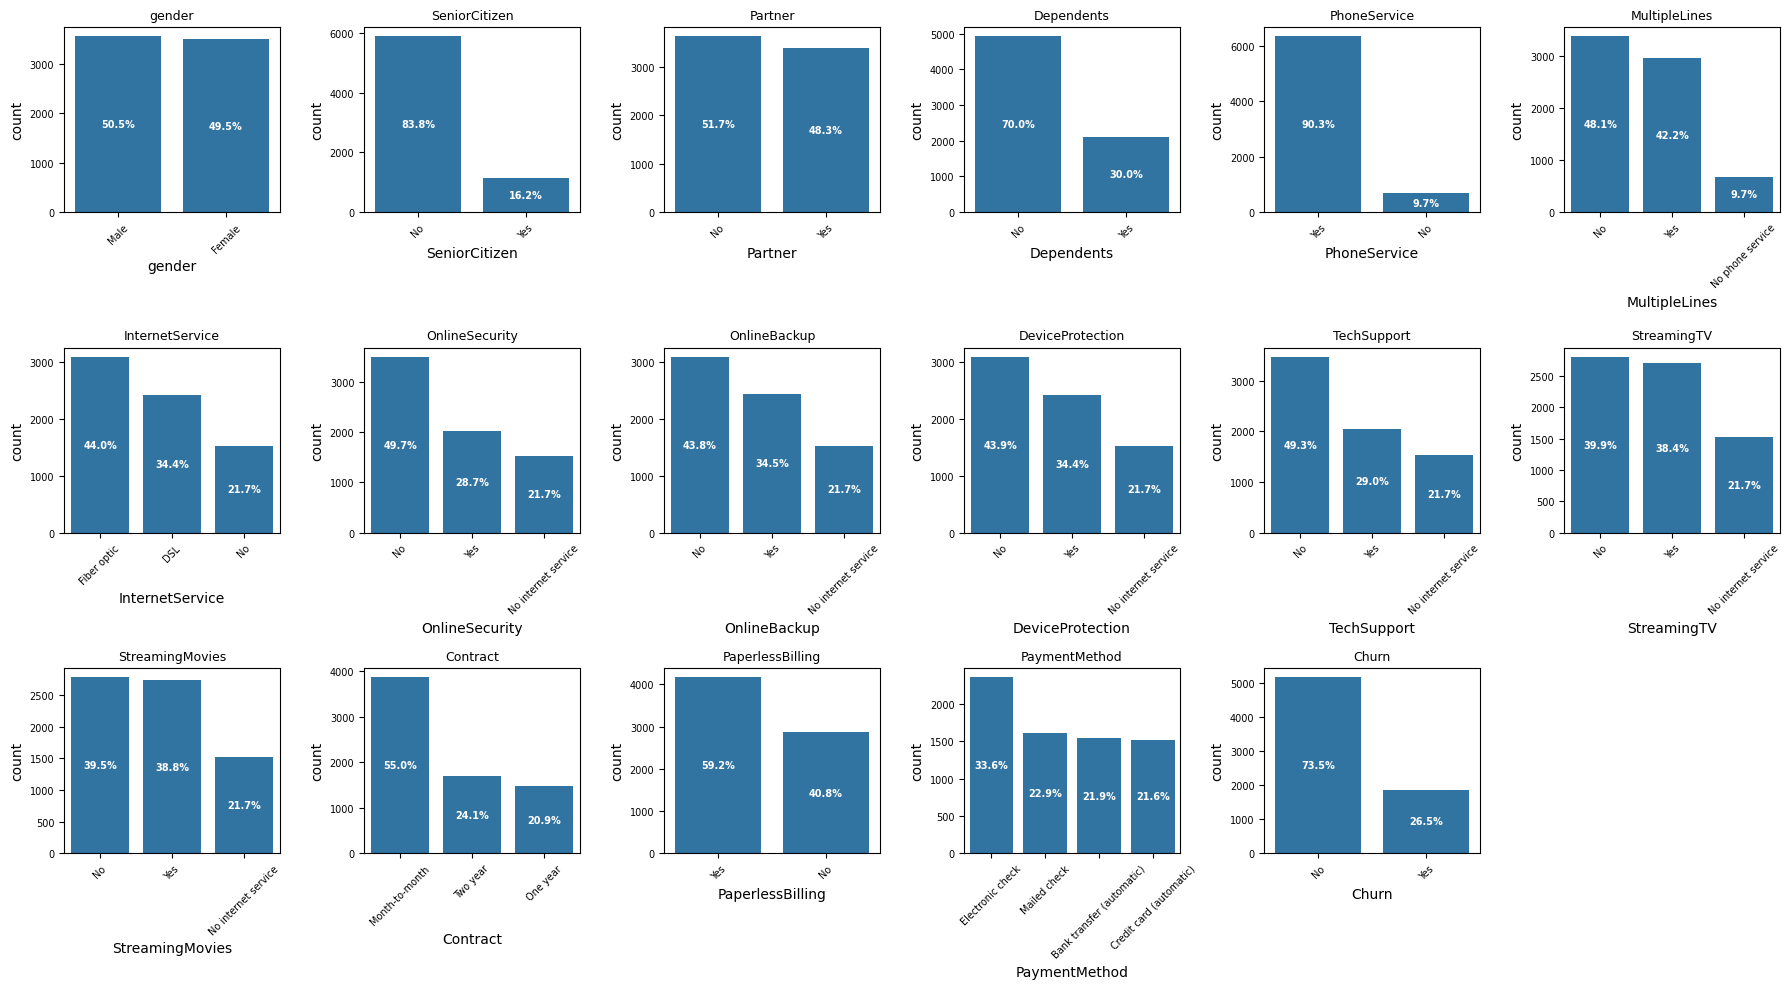

In [ ]:
plt.figure(figsize=(18, 10))

for idx, col in enumerate(cat_col):
    plt.subplot((len(cat_col)+5)//6, 6, idx+1)  # 6 kolom per baris
    ax = sns.countplot(x=datav[col], order=datav[col].value_counts().index)

    # Tambahkan persentase di setiap bar
    total = len(datav)
    for p in ax.patches:
        height = p.get_height()
        percentage = f'{100 * height / total:.1f}%'
        ax.annotate(percentage,
                    (p.get_x() + p.get_width() / 2., height / 2),
                    ha='center', va='center',
                    fontsize=7, color='white', fontweight='bold')

    plt.title(col, fontsize=9)
    plt.xticks(rotation=45, fontsize=7)
    plt.yticks(fontsize=7)
    plt.tight_layout()

plt.show()


1. Fitur Binary (2 kategori)

    Contoh: `gender, SeniorCitizen, Partner, Dependents, PhoneService, PaperlessBilling, Churn.`

    - Distribusi relatif seimbang untuk gender dan Partner.

    - Distribusi timpang pada `SeniorCitizen` (hanya 16.2% adalah senior), `PhoneService` (90.3% punya layanan), Dependents (mayoritas tidak punya tanggungan), dan Churn (hanya 26.5% churn).

    📌 Insight:

    - Ketidakseimbangan seperti ini bisa menjadi faktor penting dalam modeling (dilakukan stratified split).

    - Churn yang imbalanced perlu perhatian khusus di evaluasi (pakai metrik seperti recall dan F1-score).
    
2. Fitur Ternary atau Lebih (3+ kategori)
    Contoh: `InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaymentMethod`, dll.

    - Banyak fitur memiliki kategori "**No internet service**" atau "**No phone service**", yang pada dasarnya berarti tidak berlaku.

    - Fitur seperti `Contract` dan `PaymentMethod` punya distribusi yang berbeda-beda tapi tetap valid untuk model.

    📌 Insight:
    
    - Fitur seperti `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, dan `StreamingMovies` hanya relevan bagi pelanggan yang memiliki layanan internet.
     Ketika InternetService = No, maka semua fitur tersebut akan otomatis bernilai "No internet service".

    - Beberapa fitur seperti `Contract` dan `PaymentMethod` bisa memberi sinyal kuat terhadap churn dan layak dipertahankan dengan one-hot encoding.

## Outlier

In [ ]:
datav.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,7043.0,32.371149,24.559481,0.00,9.00,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75
TotalCharges,7043.0,2279.734304,2266.794470,0.00,398.55,1394.55,3786.60,8684.80


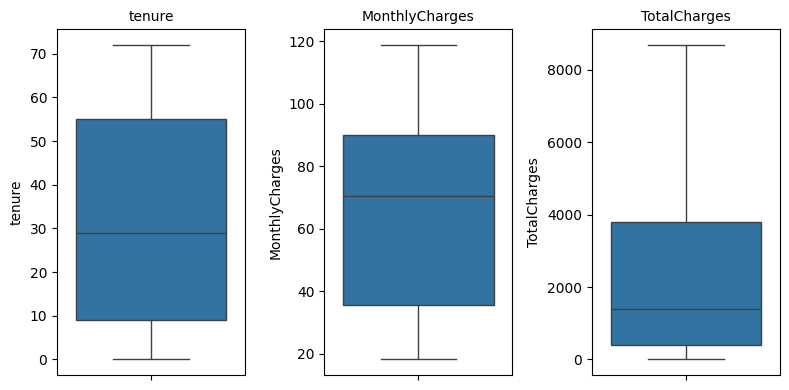

In [ ]:
plt.figure(figsize=(8, 4))

for idx, col in enumerate(num_col):
    plt.subplot(1, len(num_col), idx+1)
    sns.boxplot(y=datav[col])
    plt.title(col, fontsize=10)
    plt.tight_layout()

plt.show()

In [ ]:
# Cek outlier pakai metode IQR
for col in num_col:
    Q1 = datav[col].quantile(0.25)
    Q3 = datav[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_iqr = datav[(datav[col] < lower_bound) | (datav[col] > upper_bound)]

    print(f"Jumlah outlier di {col} (IQR method): {outliers_iqr.shape[0]}")

Jumlah outlier di tenure (IQR method): 0
Jumlah outlier di MonthlyCharges (IQR method): 0
Jumlah outlier di TotalCharges (IQR method): 0


Dengan menggunkan metde IQR tidak di dapati outlier untuk semua kolom numerik

### Correlation Matrix

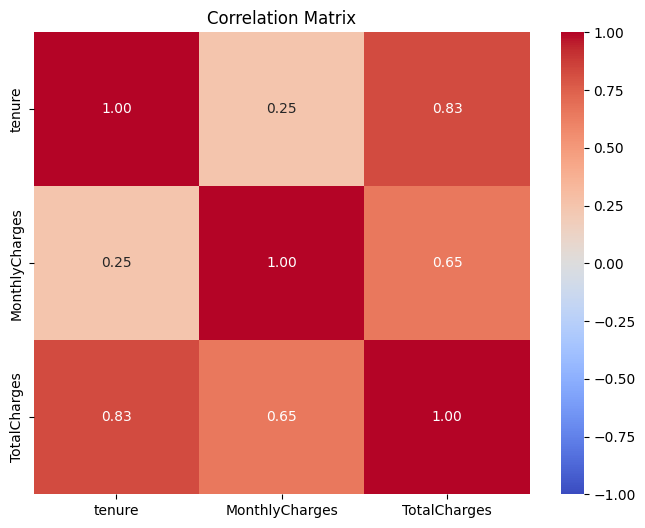

In [ ]:
# Menghitung korelasi
correlation_matrix = datav[num_col].corr()

# Membuat plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

Dari Correlation Matrix tidak di dapatkan kejangglan atau insight menarik, semua korelasi logis, semakin lama nasabah berlanggganan (`tenure`) maka semakin tinggi pula total tagihan suatu customer (`TotalCharges`) begitu juga dengan total tagihan perbulan dari seorang nasabah (`MonthlyCharges`) juga selaras dengan total tagihan nya selama terdaftar sebagai nasbaah

# **DATA PREPROCESSING**

In [ ]:
# copy data dan drop atribut customerID
data_final = datav.copy().drop('customerID', axis=1)

Disini kita akan drop kolom customer id karena fitur ini tidak relevan untuk melakukan inferensi nantinya

In [ ]:
datav.duplicated().sum()

np.int64(0)

## Handling Duplicate

In [ ]:
data_final.duplicated().sum()

np.int64(22)

Ditemukan 22 records duplikat karena kita sudah menghapus kolom id, tapi kami menetapkan untuk membiarkan duplikat ini tetap ada karena mereka adalah pelanggan berbeda dengan karakteristik yang sama, dan model perlu belajar dari semua kasus tersebut untuk menghasilkan prediksi akurat.

## Encoding

In [ ]:
# Encoding
from sklearn.preprocessing import LabelEncoder

# 1. Label Encoding untuk kolom binary
label_encode_cols = ['SeniorCitizen', 'gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']

le = LabelEncoder()
for col in label_encode_cols:
    data_final[col] = le.fit_transform(data_final[col])

# One-Hot Encoding untuk kolom kategori banyak pilihan
one_hot_encode_cols = [
    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaymentMethod'
]

# Gunakan get_dummies dan konversi boolean ke integer (0/1)
data_final = pd.get_dummies(data_final, columns=one_hot_encode_cols, dtype=int)

In [ ]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 41 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   gender                                   7043 non-null   int64  
 1   SeniorCitizen                            7043 non-null   int64  
 2   Partner                                  7043 non-null   int64  
 3   Dependents                               7043 non-null   int64  
 4   tenure                                   7043 non-null   int64  
 5   PhoneService                             7043 non-null   int64  
 6   PaperlessBilling                         7043 non-null   int64  
 7   MonthlyCharges                           7043 non-null   float64
 8   TotalCharges                             7043 non-null   float64
 9   Churn                                    7043 non-null   int64  
 10  MultipleLines_No                         7043 no

## Scalling

In [ ]:
import pandas as pd
from sklearn.preprocessing import RobustScaler

# Misal df adalah DataFrame kamu
fitur_numerik = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Inisialisasi scaler
scaler = RobustScaler()

# Terapkan scaling hanya ke kolom numerik
data_final[fitur_numerik] = scaler.fit_transform(data_final[fitur_numerik])

# Jika ingin lihat hasilnya
print(data_final[fitur_numerik].describe())

            tenure  MonthlyCharges  TotalCharges
count  7043.000000     7043.000000   7043.000000
mean      0.073286       -0.102821      0.261267
std       0.533902        0.553635      0.669056
min      -0.630435       -0.958602     -0.411608
25%      -0.434783       -0.641214     -0.293974
50%       0.000000        0.000000      0.000000
75%       0.565217        0.358786      0.706026
max       0.934783        0.890524      2.151754


Berdasarkan visualisasi distribusi fitur numerik di bagiian EDA diatas, kolom seperti `tenure`, `MonthlyCharges`, dan `TotalCharges`, terlihat bahwa ketiganya memiliki distribusi yang tidak simetris (skewed) — terutama pada `TotalCharges` dan `MonthlyCharges` yang memiliki ekor kanan panjang (right-skewed). Karena distribusi tidak simetris, penggunaan RobustScaler menjadi pilihan yang baik karena ia tidak bergantung pada mean dan standard deviation, melainkan pada median dan IQR, sehingga lebih stabil dalam mentransformasi data yang tidak terdistribusi normal. Ini penting untuk membantu model seperti SVM dan Decision Tree bekerja lebih optimal, terutama dalam menjaga struktur relatif antar data yang mungkin tersebar tidak merata.

In [ ]:
# Menyimpan dataset yang sudah di lakukan preprocessing
data_final.to_csv('data_final.csv', index=False)

# **MODELING**

## **Train-Test Split**

In [ ]:
from sklearn.model_selection import train_test_split

# Split stratified berdasarkan kolom 'Churn'
data_latih, data_uji = train_test_split(
    data_final,
    test_size=0.2,
    random_state=42,
    stratify=data_final["Churn"]
)

# Reset index
data_latih.reset_index(drop=True, inplace=True)
data_uji.reset_index(drop=True, inplace=True)

Disini kita lakukan stratify train test split mengingat perbedaan distribusi yang cukup jauh antara records churn dan non-churn agar proses traininng dan evaluasi mendapatkan hasil yang seimbang diantara dua kelas itu

## Decision Tree

Untuk decision tree disini kita menggunakna gini index sebagai cara menentukan percabangan

In [ ]:
# Hitung impurity Gini
def hitung_gini(kolom_kelas):
    elemen, banyak = np.unique(kolom_kelas, return_counts=True)
    nilai_gini = 1 - np.sum([(banyak[i] / np.sum(banyak)) ** 2 for i in range(len(elemen))])
    return nilai_gini

Fungsi hitung_gini menerima nilai kelas pada variabel tertentu dengan nilai tertentu. Nilai dan frekuensi dari masing-masing kelas dihitung menggunakan fungsi np.unique dari library numpy, kemudian dilakukan kalkulasi nilai GINI.

In [ ]:
# Hitung nilai Gini split untuk fitur kategorikal
def gini_split_kategorikal(data, nama_fitur_split, nama_fitur_kelas):
    nilai, banyak = np.unique(data[nama_fitur_split], return_counts=True)
    gini_split = np.sum([
        (banyak[i] / np.sum(banyak)) * hitung_gini(
            data[data[nama_fitur_split] == nilai[i]][nama_fitur_kelas]
        )
        for i in range(len(banyak))
    ])
    return gini_split

Fungsi `gini_split_kategorikal` digunakan untuk menghitung nilai *Gini split* dari sebuah fitur kategorikal terhadap label kelas, yang berguna dalam pemilihan fitur terbaik saat membangun pohon keputusan (*decision tree*). Fungsi ini bekerja dengan terlebih dahulu mencari semua nilai unik dari fitur kategorikal (`nama_fitur_split`) beserta jumlah kemunculannya. Kemudian, untuk setiap nilai unik tersebut, fungsi menghitung nilai Gini dari subset data yang memiliki nilai tersebut, lalu mengalikannya dengan proporsi jumlah data subset tersebut terhadap keseluruhan data. Hasil akhir dari fungsi ini adalah **nilai Gini split**, yaitu rata-rata tertimbang dari Gini impurity untuk setiap subset, yang menunjukkan seberapa baik fitur tersebut dalam membagi data berdasarkan kelas. Nilai ini digunakan untuk membandingkan fitur mana yang paling informatif saat membuat percabangan dalam decision tree.

In [ ]:
# Hitung nilai Gini split untuk fitur numerik
def gini_split_numerik(data, nama_fitur_split, nama_fitur_kelas, threshold):
    data_kiri = data[data[nama_fitur_split] <= threshold]
    data_kanan = data[data[nama_fitur_split] > threshold]
    gini_kiri = hitung_gini(data_kiri[nama_fitur_kelas])
    gini_kanan = hitung_gini(data_kanan[nama_fitur_kelas])
    gini_split = (len(data_kiri) / len(data)) * gini_kiri + (len(data_kanan) / len(data)) * gini_kanan
    return gini_split

Fungsi `gini_split_numerik` digunakan untuk menghitung nilai *Gini split* pada fitur numerik dengan menggunakan suatu nilai ambang batas (*threshold*) sebagai titik pemisah. Fungsi ini bekerja dengan membagi data menjadi dua subset, yaitu data yang nilai fiturnya kurang dari atau sama dengan threshold (`data_kiri`) dan data yang lebih besar dari threshold (`data_kanan`). Kemudian, fungsi menghitung nilai Gini impurity untuk masing-masing subset tersebut, dan menggabungkannya dengan cara rata-rata tertimbang berdasarkan proporsi jumlah data di masing-masing subset. Hasil akhirnya adalah **nilai Gini split untuk threshold tersebut**, yang menggambarkan seberapa baik threshold itu memisahkan data berdasarkan kelas, dan bisa digunakan untuk mencari threshold optimal dalam pembentukan decision tree.

In [ ]:
# Fungsi untuk mencari threshold terbaik untuk fitur numerik
def cari_split_numerik_terbaik(data, nama_fitur_split, nama_fitur_kelas):
    nilai_unik = np.unique(data[nama_fitur_split])
    threshold_coba = (nilai_unik[:-1] + nilai_unik[1:]) / 2  # Ambil tengah-tengah
    gini_splits = [gini_split_numerik(data, nama_fitur_split, nama_fitur_kelas, t) for t in threshold_coba]
    if len(gini_splits) == 0:
        return None, float('inf')
    index_terbaik = np.argmin(gini_splits)
    return threshold_coba[index_terbaik], gini_splits[index_terbaik]

Fungsi `cari_split_numerik_terbaik` digunakan untuk menentukan nilai *threshold* terbaik pada fitur numerik yang menghasilkan nilai *Gini split* paling kecil, yang berarti pemisahan data paling bersih berdasarkan kelas. Fungsi ini bekerja dengan terlebih dahulu mencari semua nilai unik dari fitur numerik yang diberikan, kemudian menghitung titik-titik tengah (*midpoints*) di antara pasangan nilai unik tersebut sebagai kandidat threshold. Untuk setiap kandidat threshold, dihitung nilai Gini split-nya menggunakan fungsi `gini_split_numerik`. Jika tidak ada threshold yang bisa dihitung (misalnya karena hanya ada satu nilai unik), fungsi akan mengembalikan `None` dan `inf` sebagai nilai default. Jika ada, fungsi mengembalikan threshold dengan nilai Gini split terkecil, yang bisa digunakan untuk membuat keputusan terbaik saat membagi node pada pohon keputusan.

    """
    Membuat pohon keputusan dari data
    
    Parameters:
    -----------
    data : DataFrame
        Data untuk membuat pohon
    data_awal : DataFrame
        Data asli (untuk kasus data kosong)
    daftar_fitur : list
        Daftar fitur yang digunakan
    nama_fitur_kelas : str
        Nama kolom kelas
    kelas_parent_node : int, optional
        Kelas mayoritas pada parent node
    
    Returns:
    --------
    dict or int
        Pohon keputusan atau nilai prediksi (0 atau 1)
    """

In [ ]:
# Memperbaiki fungsi pembuatan pohon keputusan
def buat_tree(data, data_awal, daftar_fitur, nama_fitur_kelas, kelas_parent_node=None):
    # Kasus 1: Data sudah homogen
    if len(data) > 0 and len(np.unique(data[nama_fitur_kelas])) <= 1:
        # Pastikan mengembalikan nilai integer (0 atau 1)
        return int(np.unique(data[nama_fitur_kelas])[0])

    # Kasus 2: Data kosong - ambil mayoritas dari data awal
    elif len(data) == 0:
        nilai, jumlah = np.unique(data_awal[nama_fitur_kelas], return_counts=True)
        # Pastikan mengembalikan nilai integer (0 atau 1)
        return int(nilai[np.argmax(jumlah)])

    # Kasus 3: Tidak ada fitur yang tersisa
    elif len(daftar_fitur) == 0:
        # Jika parent node tidak ada, ambil mayoritas dari data saat ini
        if kelas_parent_node is None:
            nilai, jumlah = np.unique(data[nama_fitur_kelas], return_counts=True)
            return int(nilai[np.argmax(jumlah)])
        # Jika ada parent node, gunakan nilai parent
        else:
            return int(kelas_parent_node)

    # Kasus normal: Pilih fitur terbaik dan buat split
    else:
        # Tentukan kelas mayoritas di node ini untuk digunakan sebagai nilai default
        nilai, jumlah = np.unique(data[nama_fitur_kelas], return_counts=True)
        kelas_parent_node = int(nilai[np.argmax(jumlah)])

        # Pilih split terbaik
        best_splits = []
        for fitur in daftar_fitur:
          # Cek apakah fitur numerik atau kategorikal
            if (data[fitur].dtype in ['int64', 'float64', 'int32', 'float32']):
                threshold, gini = cari_split_numerik_terbaik(data, fitur, nama_fitur_kelas)
                if threshold is not None:  # Pastikan threshold valid
                    best_splits.append((fitur, gini, threshold))
            else:
                gini = gini_split_kategorikal(data, fitur, nama_fitur_kelas)
                best_splits.append((fitur, gini, None))

        # Jika tidak ada split yang valid
        if len(best_splits) == 0:
            return kelas_parent_node

        # Cari fitur dengan Gini terkecil
        best_splits.sort(key=lambda x: x[1])
        fitur_terbaik, gini_terbaik, threshold_terbaik = best_splits[0]

        tree = {fitur_terbaik: {}}
        daftar_fitur = [i for i in daftar_fitur if i != fitur_terbaik]

        if threshold_terbaik is not None:  # fitur numerik
            data_kiri = data[data[fitur_terbaik] <= threshold_terbaik]
            data_kanan = data[data[fitur_terbaik] > threshold_terbaik]

            # Gunakan string yang konsisten untuk kondisi
            kondisi_kiri = f"<= {threshold_terbaik:.5f}"
            kondisi_kanan = f"> {threshold_terbaik:.5f}"

            tree[fitur_terbaik][kondisi_kiri] = buat_tree(
                data_kiri, data_awal, daftar_fitur, nama_fitur_kelas, kelas_parent_node
            )
            tree[fitur_terbaik][kondisi_kanan] = buat_tree(
                data_kanan, data_awal, daftar_fitur, nama_fitur_kelas, kelas_parent_node
            )

        else:  # fitur kategorikal
            # Simpan semua nilai kategorikal yang ada
            nilai_kategori = np.unique(data_awal[fitur_terbaik])

            # Proses setiap nilai kategori
            for nilai in nilai_kategori:
                sub_data = data[data[fitur_terbaik] == nilai]
                # Jika sub_data kosong, gunakan kelas mayoritas dari parent
                if len(sub_data) == 0:
                    tree[fitur_terbaik][int(nilai)] = kelas_parent_node
                else:
                    # Pastikan nilai kategori disimpan dengan tipe data yang konsisten (int)
                    tree[fitur_terbaik][int(nilai)] = buat_tree(
                        sub_data, data_awal, daftar_fitur, nama_fitur_kelas, kelas_parent_node
                    )

        return tree

Fungsi `buat_tree` merupakan inti dari algoritma *decision tree* buatan sendiri yang bekerja secara rekursif untuk membentuk struktur pohon klasifikasi dari data yang diberikan. Fungsi ini menangani berbagai kondisi khusus, seperti data yang sudah homogen (semua nilai target sama), data kosong, atau tidak ada fitur yang tersisa. Dalam kasus-kasus tersebut, fungsi akan mengembalikan nilai kelas mayoritas (baik dari data awal maupun data saat ini) agar tetap bisa menghasilkan keputusan. Selain itu, fungsi juga menetapkan nilai kelas mayoritas pada setiap node sebagai fallback jika pada proses split tidak ditemukan pembagian yang valid.

Pada kasus umum, fungsi akan memilih fitur terbaik berdasarkan nilai *Gini split* terkecil, baik dari fitur numerik maupun kategorikal. Untuk fitur numerik, digunakan threshold optimal untuk membagi data menjadi dua subset; sementara untuk fitur kategorikal, data dibagi berdasarkan setiap nilai kategorinya. Setelah pembagian, fungsi akan memanggil dirinya sendiri secara rekursif untuk masing-masing subset hingga kondisi berhenti tercapai. Struktur pohon akhir disimpan dalam bentuk nested dictionary, yang merepresentasikan jalur keputusan dari akar hingga ke daun pohon. Pendekatan ini mendekati logika pembentukan pohon pada algoritma seperti CART (*Classification and Regression Trees*), namun dibuat secara manual dan eksplisit agar lebih mudah dipahami.

In [ ]:
fitur_input = list(data_latih.columns)
fitur_input.remove("Churn")  # Hapus label dari daftar fitur

In [ ]:
tree = buat_tree(data_latih, data_latih, fitur_input, "Churn")

    """
    Memprediksi kelas berdasarkan pohon keputusan
    
    Parameters:
    -----------
    data_uji : dict
        Data uji dalam format dictionary
    tree : dict or int
        Pohon keputusan atau nilai prediksi langsung
    
    Returns:
    --------
    int
        Hasil prediksi (0 atau 1)
    """

In [ ]:
# Fungsi prediksi yang sederhana
def prediksi(data_uji, tree):
    # Jika tree bukan dictionary, berarti sudah mencapai leaf node
    if not isinstance(tree, dict):
        return int(tree)  # Pastikan mengembalikan integer

    # Ambil fitur yang digunakan di node ini
    fitur = list(tree.keys())[0]

    # Jika fitur tidak ada dalam data uji, gunakan prediksi default
    if fitur not in data_uji:
        # Ambil nilai pertama (default) dari sub-tree
        first_value = list(tree[fitur].values())[0]
        if isinstance(first_value, dict):
            return prediksi(data_uji, first_value)
        else:
            return int(first_value)

    # Nilai fitur dari data uji
    nilai_fitur = data_uji[fitur]

    # Periksa jenis node (numerik atau kategorikal)
    for kondisi, subtree in tree[fitur].items():
        # Jika kondisi berupa string dengan operator perbandingan (untuk fitur numerik)
        if isinstance(kondisi, str):
            if "<=" in kondisi:
                threshold = float(kondisi.split('<=')[1])
                if nilai_fitur <= threshold:
                    return prediksi(data_uji, subtree)
            elif ">" in kondisi:
                threshold = float(kondisi.split('>')[1])
                if nilai_fitur > threshold:
                    return prediksi(data_uji, subtree)
        # Jika kondisi berupa nilai langsung (untuk fitur kategorikal)
        elif kondisi == nilai_fitur:
            return prediksi(data_uji, subtree)

    # Jika tidak ada kondisi yang terpenuhi, ambil nilai default (subtree pertama)
    first_value = list(tree[fitur].values())[0]
    if isinstance(first_value, dict):
        return prediksi(data_uji, first_value)
    else:
        return int(first_value)

Fungsi `prediksi` digunakan untuk melakukan klasifikasi terhadap satu instance data uji berdasarkan struktur decision tree yang telah dibentuk sebelumnya. Fungsi ini bekerja secara rekursif dengan memeriksa fitur yang digunakan pada setiap node dalam pohon. Jika node yang diakses sudah berupa nilai (leaf node), maka fungsi akan langsung mengembalikannya sebagai hasil prediksi. Untuk fitur numerik, fungsi akan membandingkan nilai fitur terhadap threshold menggunakan operator `<=` atau `>` yang terenkapsulasi dalam string kondisi; sedangkan untuk fitur kategorikal, fungsi akan mencocokkan nilai secara langsung. Jika fitur tidak ditemukan dalam data uji atau tidak ada kondisi yang cocok, fungsi akan memilih salah satu subtree sebagai default untuk menjaga agar proses prediksi tetap berjalan. Pendekatan ini membuat fungsi cukup tangguh dalam menghadapi berbagai struktur pohon dan variasi data uji.

In [ ]:
data_uji_dict = data_uji.iloc[:,:-1].to_dict(orient="records")

Lakukan pengujian menggunakan data uji. Kelas pada data uji perlu dihapus dan data uji perlu diubah menjadi dictionary.

In [ ]:
hasil_prediksi_dt = []
for i in range(len(data_uji_dict)):
  hasil_prediksi = (prediksi(data_uji_dict[i], tree))
  hasil_prediksi_dt.append(hasil_prediksi)

y_pred dari decision tree yang sudah dibuat selanjutnya akan disimpan di variabel hasil_prediksi_dt dalam bentuk list

## SVM

In [ ]:
label_latih = data_latih['Churn']
label_uji = data_uji['Churn']

In [ ]:
def buat_trainingset(dataset):
  trainingset = {}
  kolom_kelas = dataset.columns[-1]
  list_kelas = dataset[kolom_kelas].unique()
  for kelas in list_kelas:
    data_temp = dataset.copy(deep=True)
    data_temp[kolom_kelas] = data_temp[kolom_kelas].map({kelas:1})
    data_temp[kolom_kelas] = data_temp[kolom_kelas].fillna(-1)
    trainingset[kelas] = data_temp
  return trainingset

In [ ]:
trainingset = buat_trainingset(data_latih)

Fungsi `buat_trainingset` bertujuan untuk memodifikasi dataset sehingga menghasilkan dictionary `trainingset` yang dapat digunakan dalam proses pelatihan model. Fungsi ini pertama-tama mengambil kolom kelas dari dataset dan memperoleh daftar kelas unik. Selanjutnya, untuk setiap kelas, fungsi ini menyalin dataset dan memodifikasi nilai pada kolom kelas: kelas yang sesuai dengan key akan diberi nilai 1, sementara kelas lainnya akan diberi nilai -1. Dictionary `trainingset` ini kemudian menyimpan hasil modifikasi dataset untuk setiap kelas, yang digunakan sebagai data latih dalam proses pelatihan model. Fungsi ini akan menghasilkan dictionary dengan key berupa kelas dan value berupa dataset yang sudah dimodifikasi sesuai dengan kelas tersebut.

In [ ]:
def hitung_cost_gradient(W,X,Y, regularization):
  jarak = 1 - (Y * np.dot(X,W))
  dw = np.zeros(len(W))
  if max(0,jarak) == 0:
    di = W
  else:
    di = W - (regularization * Y * X)
  dw += di
  return dw

Fungsi `hitung_cost_gradient` digunakan untuk menghitung nilai gradien dari cost function dalam algoritma Support Vector Machine (SVM). Tujuan dari algoritma SVM adalah meminimalkan cost function, dan untuk itu diperlukan perhitungan gradien untuk memperbarui parameter model. Fungsi ini pertama-tama menghitung jarak antara data dan margin dengan rumus `1 - (Y * np.dot(X, W))`. Jika jarak tersebut lebih besar dari 0, maka gradien diperbarui dengan mengurangkan nilai regularisasi yang disesuaikan dengan data dan bobot. Sebaliknya, jika jarak sama dengan atau lebih kecil dari 0, gradien akan tetap sama dengan bobot `W`. Fungsi ini mengembalikan gradien yang akan digunakan untuk memperbarui parameter model dalam proses optimasi.

In [ ]:
from sklearn.utils import shuffle

def sgd(data_latih, label_latih, learning_rate=0.000001, max_epoch=1000, regularization=10000):
  data_latih = data_latih.to_numpy()
  label_latih = label_latih.to_numpy()
  bobot = np.zeros(data_latih.shape[1])

  for epoch in range(1, max_epoch):
    X,Y = shuffle(data_latih, label_latih, random_state=101)
    for index, x in enumerate(X):
      delta = hitung_cost_gradient(bobot, x, Y[index], regularization)
      bobot = bobot - (learning_rate * delta)
  return bobot

Fungsi `sgd` merupakan implementasi dari algoritma Stochastic Gradient Descent (SGD) yang digunakan untuk melakukan optimasi pada model dengan meminimalkan cost function. Fungsi ini menerima input berupa data latih (`data_latih`), label latih (`label_latih`), laju pembelajaran (`learning_rate`), jumlah iterasi maksimum (`max_epoch`), dan parameter regularisasi. Dalam setiap epoch, data dan label akan di-shuffle menggunakan `shuffle` dari `sklearn.utils` untuk memastikan bahwa model tidak terjebak pada urutan data tertentu. Kemudian, untuk setiap data individu, gradien dihitung menggunakan fungsi `hitung_cost_gradient`, dan bobot model diperbarui dengan mengurangkan nilai gradien yang telah dihitung dikalikan dengan laju pembelajaran. Proses ini diulang selama jumlah epoch yang ditentukan. Hasil akhirnya adalah bobot model yang teroptimasi yang akan digunakan untuk prediksi.

In [ ]:
def training(trainingset):
  list_kelas = trainingset.keys()
  w = {}
  for kelas in list_kelas:
    data_latih = trainingset[kelas]
    label_latih = data_latih.pop(data_latih.columns[-1])
    w[kelas] = sgd(data_latih, label_latih)

  return w

In [ ]:
W = training(trainingset)

Fungsi `training` digunakan untuk melatih model pada setiap kelas yang ada dalam `trainingset`. Fungsi ini pertama-tama mengambil daftar kelas yang terdapat dalam `trainingset` dan kemudian untuk setiap kelas, mengambil dataset yang terkait. Label latih diambil dari kolom terakhir dataset dan kemudian dihapus dari data latih. Selanjutnya, fungsi `sgd` dipanggil untuk menghitung bobot model dengan data latih dan label latih yang telah dipisahkan, dan hasil bobot untuk setiap kelas disimpan dalam dictionary `w`. Setelah proses pelatihan selesai untuk semua kelas, dictionary `w` yang berisi bobot model untuk setiap kelas dikembalikan. Hasil akhir dari fungsi ini adalah dictionary `W`, yang berisi bobot model yang sudah dilatih untuk setiap kelas dalam `trainingset`.

In [ ]:
def testing(W, data_uji):
    prediksi = np.array([]).astype(int)
    # Drop kolom target (jika masih ada)
    if 'Churn' in data_uji.columns:
        data_uji = data_uji.drop(columns='Churn')

    data_uji_np = data_uji.to_numpy()

    for i in range(data_uji_np.shape[0]):
        skor = {}
        for kelas in W:
            skor[kelas] = np.dot(W[kelas], data_uji_np[i])
        prediksi = np.append(prediksi, max(skor, key=skor.get))  # kelas dengan skor tertinggi

    return prediksi

In [ ]:
hasil_prediksi_svm = testing(W, data_uji)

Fungsi `testing` digunakan untuk melakukan prediksi pada data uji berdasarkan bobot model yang telah dilatih sebelumnya. Fungsi ini pertama-tama memeriksa apakah ada kolom target yang bernama 'Churn' dalam `data_uji` dan jika ada, kolom tersebut dihapus. Kemudian, data uji diubah menjadi array numpy untuk memudahkan perhitungan. Untuk setiap baris data uji, fungsi menghitung skor untuk setiap kelas dengan cara mengalikan bobot kelas yang relevan dengan data uji tersebut menggunakan operasi dot product (`np.dot`). Kelas dengan skor tertinggi akan dipilih sebagai prediksi untuk baris data tersebut. Prediksi untuk semua data uji akan disimpan dalam array `prediksi`, yang kemudian dikembalikan sebagai hasil akhir. Hasil dari fungsi ini adalah array yang berisi prediksi kelas untuk setiap data uji berdasarkan model yang sudah dilatih.

## Random Forest


In [ ]:
! wget https://raw.githubusercontent.com/Muzann11/KA-lanjutan/main/data_final.csv

--2025-05-01 03:02:28--  https://raw.githubusercontent.com/Muzann11/KA-lanjutan/main/data_final.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 951539 (929K) [text/plain]
Saving to: ‘data_final.csv’

data_final.csv      100%[===================>] 929.24K  --.-KB/s    in 0.01s   

2025-05-01 03:02:28 (70.7 MB/s) - ‘data_final.csv’ saved [951539/951539]



In [ ]:
data_final = pd.read_csv('data_final.csv')

In [ ]:
from sklearn.model_selection import train_test_split

# Split stratified berdasarkan kolom 'Churn'
data_latih, data_uji = train_test_split(
    data_final,
    test_size=0.2,
    random_state=42,
    stratify=data_final["Churn"]
)

# Reset index
data_latih.reset_index(drop=True, inplace=True)
data_uji.reset_index(drop=True, inplace=True)

In [ ]:
X_train = data_latih.drop(columns=["Churn"])
y_train = data_latih["Churn"]
X_test = data_uji.drop(columns=["Churn"])
y_test = data_uji["Churn"]

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
hasil_prediksi_rf = rf_model.predict(X_test)

# **EVALUASI**

## Fungsi-Fungsi Untuk Evaluasi

In [ ]:
def confusion_matrix_manual(y_true, y_pred, labels):
  num_classes = len(labels)

  # Inisialisasi matriks dengan ukuran (jumlah class)
  confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)

  # Mengisi matriks
  for true, pred in zip (y_true, y_pred):
    confusion_matrix[true, pred] += 1

  return confusion_matrix

Fungsi `confusion_matrix_manual` digunakan untuk menghitung matriks kebingunguan (confusion matrix) secara manual, yang menunjukkan performa prediksi model dengan membandingkan nilai prediksi (`y_pred`) dan nilai sebenarnya (`y_true`) berdasarkan kelas yang telah ditentukan. Fungsi ini menerima tiga parameter: `y_true` (nilai kelas yang sebenarnya), `y_pred` (nilai kelas yang diprediksi), dan `labels` (daftar kelas yang mungkin). Pertama, fungsi menginisialisasi sebuah matriks kebingunguan berukuran (jumlah kelas x jumlah kelas) dengan nilai nol. Kemudian, untuk setiap pasangan nilai `true` dan `pred`, nilai pada matriks kebingunguan akan diperbarui dengan menambah 1 pada posisi yang sesuai, di mana baris menunjukkan kelas yang benar dan kolom menunjukkan kelas yang diprediksi. Matriks yang dihasilkan akan menggambarkan berapa kali setiap kombinasi kelas yang benar dan yang diprediksi terjadi. Fungsi ini mengembalikan matriks kebingunguan yang dapat digunakan untuk menganalisis performa model.

In [ ]:
def calculate_metrics (confusion_matrix, labels):
  num_classes = confusion_matrix.shape[0]
  metrics = {}
  for i in range(num_classes):
    TP = confusion_matrix[i, i]
    FP = confusion_matrix[:, i].sum() - TP
    FN = confusion_matrix[i, :].sum() - TP
    TN = confusion_matrix.sum() - (TP + FP+ FN)
    metrics[labels[i]] = {
        "TP": TP,
        "FP": FP,
        "FN": FN,
        "TN": TN
        }
  return metrics

Fungsi `calculate_metrics` digunakan untuk menghitung metrik evaluasi dari matriks kebingunguan (confusion matrix), seperti True Positive (TP), False Positive (FP), False Negative (FN), dan True Negative (TN) untuk setiap kelas. Fungsi ini menerima dua parameter: `confusion_matrix` (matriks kebingunguan yang dihitung sebelumnya) dan `labels` (daftar kelas yang digunakan dalam perhitungan).

Fungsi ini pertama-tama menginisialisasi sebuah dictionary `metrics` untuk menyimpan nilai-nilai metrik untuk setiap kelas. Kemudian, untuk setiap kelas (ditandai dengan indeks `i`), fungsi menghitung:
- **TP** (True Positive): Jumlah prediksi yang benar untuk kelas tersebut.
- **FP** (False Positive): Jumlah data yang salah dikategorikan sebagai kelas tersebut, dihitung dengan menjumlahkan seluruh kolom pada matriks kebingunguan untuk kelas tersebut, kecuali TP.
- **FN** (False Negative): Jumlah data yang benar dari kelas tersebut tetapi salah diprediksi sebagai kelas lain, dihitung dengan menjumlahkan seluruh baris pada matriks kebingunguan untuk kelas tersebut, kecuali TP.
- **TN** (True Negative): Jumlah data yang tidak termasuk dalam kelas tersebut dan diprediksi dengan benar sebagai kelas selain kelas yang diuji, dihitung dengan mengurangi jumlah TP, FP, dan FN dari total jumlah elemen dalam matriks.

Fungsi ini akan mengembalikan sebuah dictionary `metrics` yang menyimpan metrik untuk setiap kelas, yang dapat digunakan untuk menilai performa model dalam setiap kelas.

In [ ]:
def normalize_confusion_matrix(cm):
    """
    Fungsi untuk melakukan normalisasi pada hasil confusion matrix dengan rentang 0-1

    parameter :
      cm : confusion matrix yang akan dinormalisasi
    return
      cm_normalized : confusion matrix yang sudah dinormalisasi
    """
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    return cm_normalized

Fungsi `normalize_confusion_matrix` digunakan untuk menormalisasi matriks kebingunguan dengan membagi setiap elemen matriks dengan jumlah elemen pada baris yang sesuai, menghasilkan nilai dalam rentang 0 hingga 1. Ini membantu dalam mengevaluasi performa model dengan lebih adil, mengingat perbedaan jumlah data di setiap kelas. Fungsi ini mengembalikan matriks kebingunguan yang sudah dinormalisasi.

In [ ]:
def calculate_precision(metrics):
    """
    Menghitung precision per kelas dan rata-rata precision.

    Parameter:
        metrics : dict hasil dari calculate_metrics()

    Return:
        precision_per_class : dict {label: precision}
        avg_precision : float
    """
    precision_per_class = {}
    total_precision = 0
    num_classes = len(metrics)

    for label, metric in metrics.items():
        TP = metric["TP"]
        FP = metric["FP"]
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        precision_per_class[label] = precision
        total_precision += precision

    avg_precision = total_precision / num_classes
    return precision_per_class, avg_precision

Fungsi `calculate_precision` digunakan untuk menghitung nilai precision per kelas serta rata-rata precision untuk semua kelas berdasarkan metrik yang dihitung sebelumnya. Fungsi ini menerima input berupa dictionary `metrics` yang dihasilkan dari fungsi `calculate_metrics()`, yang berisi nilai TP dan FP untuk setiap kelas. Precision untuk setiap kelas dihitung dengan rumus TP / (TP + FP), dan jika jumlah TP + FP sama dengan nol, precision diatur menjadi nol. Nilai precision per kelas disimpan dalam dictionary `precision_per_class`, sementara rata-rata precision dihitung dengan menjumlahkan semua precision dan membaginya dengan jumlah kelas. Fungsi ini mengembalikan dictionary precision per kelas serta rata-rata precision untuk seluruh kelas.

In [ ]:
def calculate_recall(metrics):
    """
    Menghitung recall per kelas dan rata-rata recall.

    Parameter:
        metrics : dict hasil dari calculate_metrics()

    Return:
        recall_per_class : dict {label: recall}
        avg_recall : float
    """
    recall_per_class = {}
    total_recall = 0
    num_classes = len(metrics)

    for label, metric in metrics.items():
        TP = metric["TP"]
        FN = metric["FN"]
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        recall_per_class[label] = recall
        total_recall += recall

    avg_recall = total_recall / num_classes
    return recall_per_class, avg_recall


Fungsi `calculate_recall` digunakan untuk menghitung nilai recall per kelas serta rata-rata recall untuk semua kelas berdasarkan metrik yang dihitung sebelumnya. Fungsi ini menerima input berupa dictionary `metrics` yang dihasilkan dari fungsi `calculate_metrics()`, yang berisi nilai TP dan FN untuk setiap kelas. Recall dihitung dengan rumus TP / (TP + FN), dan jika jumlah TP + FN sama dengan nol, recall diatur menjadi nol. Nilai recall per kelas disimpan dalam dictionary `recall_per_class`, sementara rata-rata recall dihitung dengan menjumlahkan semua recall dan membaginya dengan jumlah kelas. Fungsi ini mengembalikan dictionary recall per kelas serta rata-rata recall untuk seluruh kelas.

In [ ]:
def calculate_f1_score(metrics):
    """
    Menghitung f1-score per kelas dan rata-rata f1-score.

    Parameter:
        metrics : dict hasil dari calculate_metrics()

    Return:
        f1_per_class : dict {label: f1-score}
        avg_f1 : float
    """
    f1_per_class = {}
    total_f1 = 0
    num_classes = len(metrics)

    for label, metric in metrics.items():
        TP = metric["TP"]
        FP = metric["FP"]
        FN = metric["FN"]
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1_per_class[label] = f1
        total_f1 += f1

    avg_f1 = total_f1 / num_classes
    return f1_per_class, avg_f1


Fungsi `calculate_f1_score` digunakan untuk menghitung nilai F1-score per kelas serta rata-rata F1-score untuk seluruh kelas berdasarkan metrik yang dihitung sebelumnya. Fungsi ini menerima input berupa dictionary `metrics` yang dihasilkan dari fungsi `calculate_metrics()`, yang berisi nilai TP, FP, dan FN untuk setiap kelas. F1-score dihitung dengan rumus 2 * (precision * recall) / (precision + recall), dengan precision dan recall dihitung terlebih dahulu. Jika jumlah precision dan recall adalah nol, F1-score diatur menjadi nol. Nilai F1-score per kelas disimpan dalam dictionary `f1_per_class`, sementara rata-rata F1-score dihitung dengan menjumlahkan semua F1-score dan membaginya dengan jumlah kelas. Fungsi ini mengembalikan dictionary F1-score per kelas serta rata-rata F1-score untuk seluruh kelas.

In [ ]:
def calculate_accuracy_score(metrics):
    """
    Fungsi untuk menghitung accuracy_score

    parameter :
      metrics : hasil fungsi calculate_metrics
    return
      accuracy : nilai accuracy_score
    """
    total_accuracy = 0
    num_classes = len(metrics)

    for label, metric in metrics.items():
        accuracy = (metric['TP'] + metric['TN']) / (metric['TP'] + metric['FP'] + metric['FN'] + metric['TN'])
        total_accuracy += accuracy

    avg_accuracy = total_accuracy / num_classes
    return avg_accuracy

Fungsi `calculate_accuracy_score` digunakan untuk menghitung nilai *accuracy score* rata-rata berdasarkan metrik yang dihitung sebelumnya. Fungsi ini menerima input berupa dictionary `metrics`, yang berisi nilai TP, FP, FN, dan TN untuk setiap kelas. Untuk setiap kelas, *accuracy* dihitung dengan rumus (TP + TN) / (TP + FP + FN + TN), yang menunjukkan proporsi prediksi yang benar (baik positif maupun negatif) dibandingkan dengan total prediksi. Nilai *accuracy* per kelas dijumlahkan, dan rata-rata *accuracy* dihitung dengan membaginya dengan jumlah kelas. Fungsi ini mengembalikan rata-rata *accuracy* untuk seluruh kelas.

In [ ]:
def cm_plot(cm, true_labels, predictions):
    """
    Menampilkan visualisasi Confusion Matrix dalam bentuk heatmap.

    Parameter:
    - cm : array-like
        Confusion matrix hasil prediksi model (bisa dinormalisasi atau tidak).
    - true_labels : array-like
        Label sebenarnya (ground truth) dari data.
    - predictions : array-like
        Label hasil prediksi dari model.
    - labels : array-like
        Daftar semua label unik pada kelas target.

    Output:
    - Menampilkan plot heatmap Confusion Matrix menggunakan seaborn.
    """
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Fungsi `cm_plot` digunakan untuk menampilkan visualisasi matriks kebingunguan (Confusion Matrix) dalam bentuk heatmap menggunakan seaborn. Fungsi ini menerima tiga parameter utama: `cm` yang berisi matriks kebingunguan hasil prediksi model (bisa dalam bentuk normalisasi atau tidak), `true_labels` yang merupakan label sebenarnya dari data, dan `predictions` yang merupakan hasil prediksi model. Fungsi ini juga menggunakan `sns.heatmap` untuk memplot matriks kebingunguan dengan anotasi untuk setiap elemen, serta menampilkan label pada sumbu X dan Y berdasarkan kelas target yang unik. Outputnya adalah visualisasi heatmap yang menggambarkan hubungan antara label yang sebenarnya dan hasil prediksi.

## Persiapan Variabel

In [ ]:
# Label asli
y_true = data_uji["Churn"].tolist()

# Label prediksi Decision Tree
y_pred_dt = hasil_prediksi_dt

# Label prediksi Decision Tree
y_pred_svm = hasil_prediksi_svm

# Label prediksi Random Forest
y_pred_rf = hasil_prediksi_rf

# Pastikan label sudah diketahui (misalnya dari data latih)
labels = np.unique(data_latih["Churn"]).tolist()

# Hitung confusion matrix
conf_matrix_dt = confusion_matrix_manual(y_true, y_pred_dt, labels)

conf_matrix_svm = confusion_matrix_manual(y_true, y_pred_svm, labels)

conf_matrix_rf = confusion_matrix_manual(y_true, y_pred_rf, labels)

# Hitung metrik evaluasi
metrics_dt = calculate_metrics(conf_matrix_dt, labels)

metrics_svm = calculate_metrics(conf_matrix_svm, labels)

metrics_rf = calculate_metrics(conf_matrix_rf, labels)


## **Evaluasi Decision Tree**

In [ ]:
precision_dt, avg_precision_dt = calculate_precision(metrics_dt)
recall_dt, avg_recall_dt = calculate_recall(metrics_dt)
f1_dt, avg_f1_dt = calculate_f1_score(metrics_dt)
accuracy_dt = calculate_accuracy_score(metrics_dt)

print("Accuracy :", accuracy_dt)
print("Precision per kelas:", precision_dt)
print("Recall per kelas:", recall_dt)
print("F1-score per kelas:", f1_dt)
print("\nRata-rata: ")
print(f"Precision: {avg_precision_dt:.2f}, Recall: {avg_recall_dt:.2f}, F1: {avg_f1_dt:.2f}")

Accuracy : 0.7139815471965933
Precision per kelas: {0: np.float64(0.800952380952381), 1: np.float64(0.4596100278551532)}
Recall per kelas: {0: np.float64(0.81256038647343), 1: np.float64(0.4411764705882353)}
F1-score per kelas: {0: np.float64(0.8067146282973622), 1: np.float64(0.4502046384720328)}

Rata-rata: 
Precision: 0.63, Recall: 0.63, F1: 0.63


In [ ]:
# Cetak hasil
print("Confusion Matrix DT:")
print(conf_matrix_dt)

Confusion Matrix DT:
[[841 194]
 [209 165]]


In [ ]:
norm_cm_dt = normalize_confusion_matrix(conf_matrix_dt)

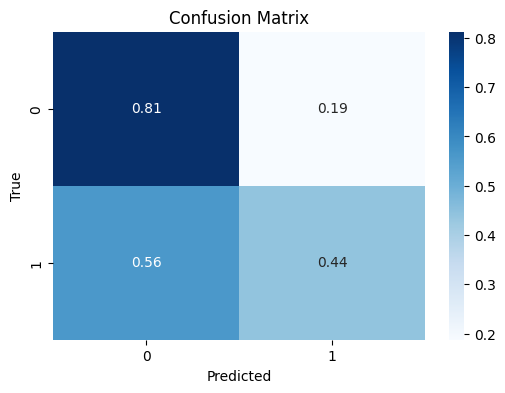

In [ ]:
cm_plot(norm_cm_dt, y_true, y_pred_dt)

Perbandingan dengan DecisionTreeClassifier dari library scikit-learn

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Misalnya: data_latih dan data_uji sudah dibagi seperti ini
X_latih = data_latih.drop("Churn", axis=1)
y_latih = data_latih["Churn"]
X_uji = data_uji.drop("Churn", axis=1)
y_uji = data_uji["Churn"].tolist()

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Membuat model Decision Tree
model = DecisionTreeClassifier(random_state=42)
model.fit(X_latih, y_latih)

# Prediksi data uji
y_pred_sklearn_dt = model.predict(X_uji)

# Evaluasi hasil prediksi
print("Akurasi:", accuracy_score(y_uji, y_pred_sklearn_dt))
print("\nLaporan klasifikasi:\n", classification_report(y_uji, y_pred_sklearn_dt))

Akurasi: 0.7253371185237757

Laporan klasifikasi:
               precision    recall  f1-score   support

           0       0.82      0.81      0.81      1035
           1       0.48      0.50      0.49       374

    accuracy                           0.73      1409
   macro avg       0.65      0.65      0.65      1409
weighted avg       0.73      0.73      0.73      1409



In [ ]:
# Confusion matrix
cm = confusion_matrix(y_uji, y_pred_sklearn_dt)
print(cm, "\n")

[[834 201]
 [186 188]] 



## **Evaluasi SVM**

In [ ]:
precision_svm, avg_precision_svm = calculate_precision(metrics_svm)
recall_svm, avg_recall_svm = calculate_recall(metrics_svm)
f1_svm, avg_f1_svm = calculate_f1_score(metrics_svm)
accuracy_svm = calculate_accuracy_score(metrics_svm)

print("Accuracy :", accuracy_svm)
print("Precision per kelas:", precision_svm)
print("Recall per kelas:", recall_svm)
print("F1-score per kelas:", f1_svm)
print("\nRata-rata: ")
print(f"Precision: {avg_precision_svm:.2f}, Recall: {avg_recall_svm:.2f}, F1: {avg_f1_svm:.2f}")

Accuracy : 0.602555003548616
Precision per kelas: {0: np.float64(0.7141568981064021), 1: np.float64(0.19)}
Recall per kelas: {0: np.float64(0.7652173913043478), 1: np.float64(0.15240641711229946)}
F1-score per kelas: {0: np.float64(0.7388059701492538), 1: np.float64(0.16913946587537093)}

Rata-rata: 
Precision: 0.45, Recall: 0.46, F1: 0.45


In [ ]:
# Cetak hasil
print("Confusion Matrix SVM:")
print(conf_matrix_svm)

Confusion Matrix SVM:
[[792 243]
 [317  57]]


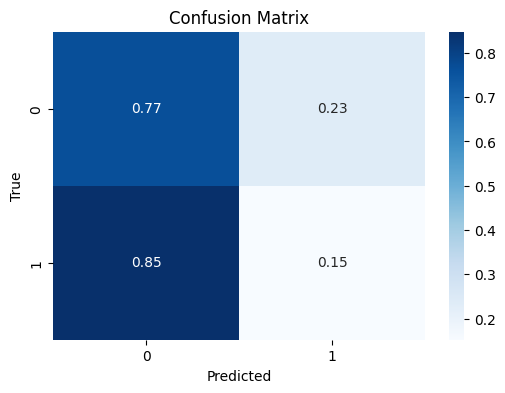

In [ ]:
norm_cm_svm = normalize_confusion_matrix(conf_matrix_svm)

cm_plot(norm_cm_svm, y_true, y_pred_svm)

Perbandingan dengan SVM Classifier dari scikit-learn

In [ ]:
from sklearn.svm import SVC
# Inisialisasi dan latih model SVM
svm_model = SVC(kernel='linear', random_state=101)
svm_model.fit(X_latih, y_latih)

# Prediksi data uji
y_pred_sklearn_svm = svm_model.predict(X_uji)

# Evaluasi hasil prediksi
print("Akurasi SVM sklearn:", accuracy_score(y_uji, y_pred_sklearn_svm))
print("\nLaporan klasifikasi SVM sklean:\n", classification_report(y_uji, y_pred_sklearn_svm))

Akurasi SVM sklearn: 0.7877927608232789

Laporan klasifikasi SVM sklean:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86      1035
           1       0.62      0.53      0.57       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



In [ ]:
# confusion matrix
cm = confusion_matrix(y_uji, y_pred_sklearn_svm)

print(cm, "\n")

[[913 122]
 [177 197]] 



## **Evaluasi Random Forest**

In [ ]:
precision_rf, avg_precision_rf = calculate_precision(metrics_rf)
recall_rf, avg_recall_rf = calculate_recall(metrics_rf)
f1_rf, avg_f1_rf = calculate_f1_score(metrics_rf)
accuracy_rf = calculate_accuracy_score(metrics_rf)

print("Accuracy :", accuracy_rf)
print("Precision per kelas:", precision_rf)
print("Recall per kelas:", recall_rf)
print("F1-score per kelas:", f1_rf)
print("\nRata-rata: ")
print(f"Precision: {avg_precision_rf:.2f}, Recall: {avg_recall_rf:.2f}, F1: {avg_f1_rf:.2f}")

Accuracy : 0.7821149751596878
Precision per kelas: {0: np.float64(0.8297101449275363), 1: np.float64(0.6098360655737705)}
Recall per kelas: {0: np.float64(0.885024154589372), 1: np.float64(0.49732620320855614)}
F1-score per kelas: {0: np.float64(0.8564749883122955), 1: np.float64(0.5478645066273932)}

Rata-rata: 
Precision: 0.72, Recall: 0.69, F1: 0.70


In [ ]:
# Cetak hasil
print("Confusion Matrix RT:")
print(conf_matrix_rf)

Confusion Matrix RT:
[[916 119]
 [188 186]]


In [ ]:
norm_cm_rf = normalize_confusion_matrix(conf_matrix_rf)

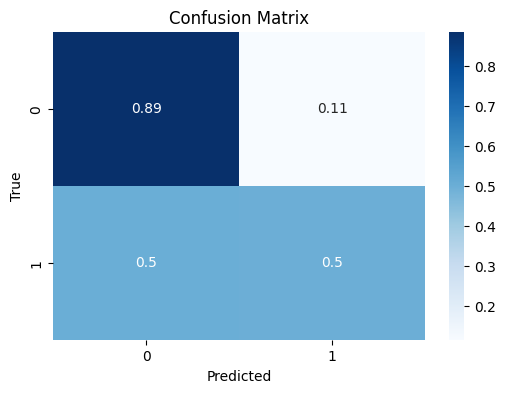

In [ ]:
cm_plot(norm_cm_rf, y_true, y_pred_rf)

# **TEMUAN (secara ringkas)**

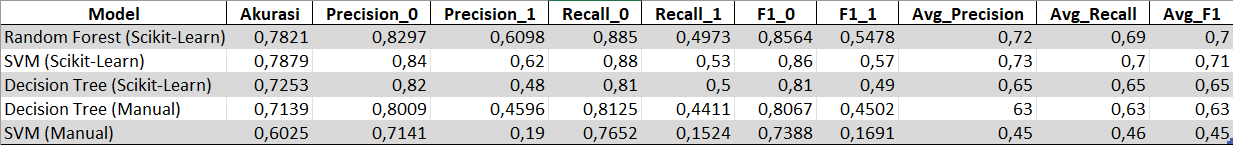

1. Distribusi Data Tidak Seimbang Churn (Yes) hanya 26.54% dari total data Tidak churn (No) mendominasi sebesar 73.46%

  Model cenderung memprioritaskan prediksi untuk kelas mayoritas (tidak churn), sehingga performa terhadap kelas minoritas (churn) bisa tertinggal, meskipun akurasinya tinggi. Oleh karena itu, metrik seperti `Recall_1, Precision_1, dan F1_1` menjadi fokus utama evaluasi.

2. Fokus pada Kelas '1' (Churn)
Karena churn berarti kehilangan pelanggan dan pendapatan, maka model yang mampu mendeteksi sebanyak mungkin pelanggan churn secara akurat dan seimbang menjadi sangat penting. Kita fokus pada:
  * `Recall_1` → Seberapa banyak churn yang berhasil dikenali
  * `Precision_1` → Seberapa akurat prediksi churn-nya
  * `F1_1` → Keseimbangan antara keduanya

3. Perbandingan performa model dan model terbaik
  * `SVM (scikit-learn)` : Terbaik secara keseluruhan dalam mendeteksi churn
  * `Random Forest (Scikit-Learn)` : Cukup baik, alternatif kedua
  * `Decision Tree (Scikit-Learn)` : Seimbang, tapi kurang akurat
  * `Decision Tree (Manual)` : Kurang optimal
  * `SVM (Manual) ` : Sangat buruk dalam mendeteksi churn

4. Performa model manual dan scikit, mana yang lebih baik?

  model manual decision tree dan SVM memiliki performa yang lebih rendah dibandingkan model yang dibangun dengan scikit learn, ini dikarenakan model yang dibuat secara manual tidak sefleksibel dan seoptimal mode scikit learn. Model yang dibuat manual tidak mendukung optimasi otomatis, dan kurang mampu menangkap pola kompleks. Karena itu, untuk kasus churn prediction dengan data yang tidak seimbang, model Scikit-Learn lebih akurat dan efektif.

  jadi `kesimpulannya, model scikit learn lebih baik` jika dibandingkan dengan model yang dibuat secara manual